In [1]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

# Загрузка данных

**Описание датасета**

1.   sex: 1 for female and 2 for male.
2.   age: of the patient.
3.   classification: covid test findings. Values 1-3 mean that the patient was diagnosed with covid in different
degrees. 4 or higher means that the patient is not a carrier of covid or that the test is inconclusive.
4.  patient type: type of care the patient received in the unit. 1 for returned home and 2 for hospitalization.
5. pneumonia: whether the patient already have air sacs inflammation or not.
6. pregnancy: whether the patient is pregnant or not.
7. diabetes: whether the patient has diabetes or not.
8. copd: Indicates whether the patient has Chronic obstructive pulmonary disease or not.
9. asthma: whether the patient has asthma or not.
10. inmsupr: whether the patient is immunosuppressed or not.
11. hypertension: whether the patient has hypertension or not.
12. cardiovascular: whether the patient has heart or blood vessels related disease.
renal chronic: whether the patient has chronic renal disease or not.
13. other disease: whether the patient has other disease or not.
14. obesity: whether the patient is obese or not.
15. tobacco: whether the patient is a tobacco user.
16. usmr: Indicates whether the patient treated medical units of the first, second or third level.
17. medical unit: type of institution of the National Health System that provided the care.
18. intubed: whether the patient was connected to the ventilator.
19. icu: Indicates whether the patient had been admitted to an Intensive Care Unit.
20. date died: If the patient died indicate the date of death, and 9999-99-99 otherwise.




In [15]:
df = pd.read_csv('Covid Data.csv')
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97.0,1.0,65.0,2.0,2.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0
1,2,1,2,1,03/06/2020,97.0,1.0,72.0,97.0,2.0,...,2.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5.0,97.0
2,2,1,2,2,09/06/2020,1.0,2.0,55.0,97.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0
3,2,1,1,1,12/06/2020,97.0,2.0,53.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,97.0
4,2,1,2,1,21/06/2020,97.0,2.0,68.0,97.0,1.0,...,2.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 532309 entries, 0 to 532308
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   USMER                 532309 non-null  int64  
 1   MEDICAL_UNIT          532309 non-null  int64  
 2   SEX                   532309 non-null  int64  
 3   PATIENT_TYPE          532309 non-null  int64  
 4   DATE_DIED             532309 non-null  object 
 5   INTUBED               532308 non-null  float64
 6   PNEUMONIA             532308 non-null  float64
 7   AGE                   532308 non-null  float64
 8   PREGNANT              532308 non-null  float64
 9   DIABETES              532308 non-null  float64
 10  COPD                  532308 non-null  float64
 11  ASTHMA                532308 non-null  float64
 12  INMSUPR               532308 non-null  float64
 13  HIPERTENSION          532308 non-null  float64
 14  OTHER_DISEASE         532308 non-null  float64
 15  

# 1. EDA

 **Целевая переменная**

Text(0.5, 0, 'Alive')

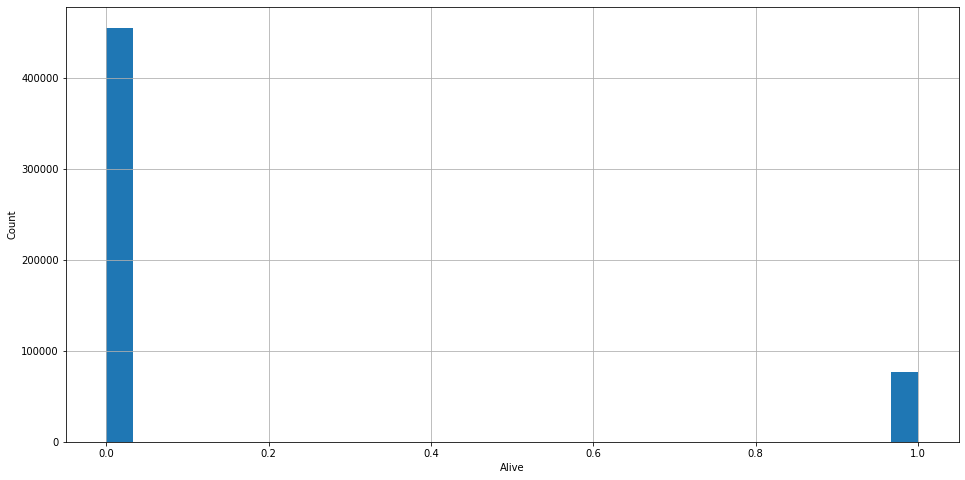

In [17]:
plt.figure(figsize = (16, 8))
# Изменим значения date_died на 0 - в случае, если пациент жив, на 1 в противном 0
df.loc[(df['DATE_DIED'] == '9999-99-99'), 'DATE_DIED'] = 0
df.loc[(df['DATE_DIED'] != 0), 'DATE_DIED'] = 1
df['DATE_DIED'] = df['DATE_DIED'].astype(int)
df = df.rename(columns={'DATE_DIED':'DIED'})

df['DIED'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Alive')

**Количественные переменные**

In [18]:
df.describe()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
count,532309.000000,532309.000000,532309.000000,532309.000000,532309.000000,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000,...,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000,532308.000000
mean,1.584546,6.050260,1.515839,1.303125,0.144429,69.001127,3.594800,44.219882,51.183839,2.223776,...,2.318019,2.385534,2.161709,2.463078,2.334406,2.180965,2.324545,2.298786,4.775671,69.041562
std,0.492801,3.140973,0.499750,0.459609,0.351525,43.397200,13.136509,17.264984,47.479907,6.022492,...,5.786499,6.205779,5.869378,6.950161,5.866740,5.816267,5.797654,6.011548,1.899715,43.342071
min,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,4.000000,1.000000,1.000000,0.000000,2.000000,2.000000,32.000000,2.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,3.000000,2.000000
50%,2.000000,4.000000,2.000000,1.000000,0.000000,97.000000,2.000000,43.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,5.000000,97.000000
75%,2.000000,9.000000,2.000000,2.000000,0.000000,97.000000,2.000000,56.000000,97.000000,2.000000,...,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,7.000000,97.000000
max,2.000000,12.000000,2.000000,2.000000,1.000000,99.000000,99.000000,120.000000,98.000000,98.000000,...,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,98.000000,7.000000,99.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2d87cd1dc0>,
      dtype=object)

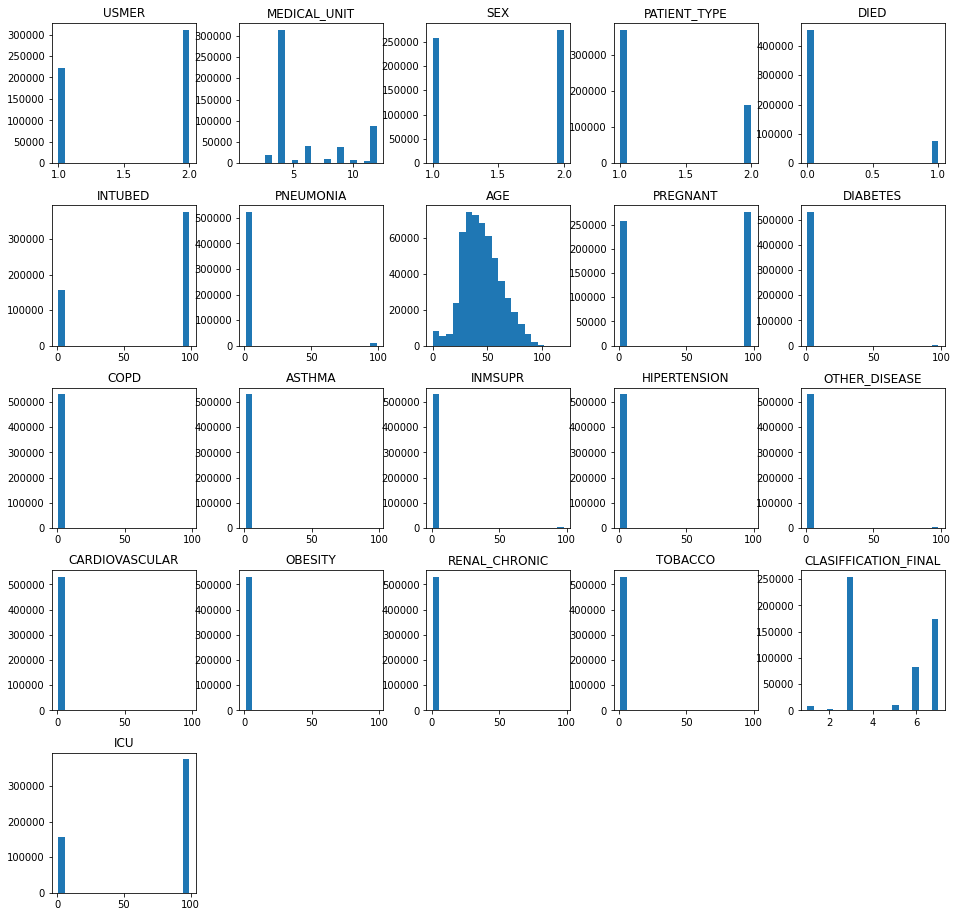

In [19]:
df.hist(figsize=(16,16), bins=20, grid=False)

# 2. Обработка выбросов (не требуется)

# 3. Обработка пропусков


In [27]:
df.isna().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DIED                    0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

In [28]:
 df.drop(df.tail(1).index,inplace=True)
 df.isna().sum()

USMER                   0
MEDICAL_UNIT            0
SEX                     0
PATIENT_TYPE            0
DIED                    0
INTUBED                 0
PNEUMONIA               0
AGE                     0
PREGNANT                0
DIABETES                0
COPD                    0
ASTHMA                  0
INMSUPR                 0
HIPERTENSION            0
OTHER_DISEASE           0
CARDIOVASCULAR          0
OBESITY                 0
RENAL_CHRONIC           0
TOBACCO                 0
CLASIFFICATION_FINAL    0
ICU                     0
dtype: int64

# 4. Построение новых признаков

**IllDeathReason**

In [49]:
ill_death_reason = df.groupby(['PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY'], as_index=False).agg({'DIED': 'median'}) \
                    .rename(columns={'DIED':'IllDeathReason'})
ill_death_reason.head(20)      

,PNEUMONIA,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,CARDIOVASCULAR,OBESITY,IllDeathReason
0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0
1,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,0.0
2,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,0.5
3,1.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,0.0
4,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,0.0
5,1.0,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0
6,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0
7,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0
8,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0
9,1.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,1.0


In [50]:
df = df.merge(ill_death_reason, on=['PNEUMONIA', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'CARDIOVASCULAR', 'OBESITY'], how='left')
df.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,IllDeathReason
0,2,1,1,1,1,97.0,1.0,65.0,2.0,2.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0,1.0
1,2,1,2,1,1,97.0,1.0,72.0,97.0,2.0,...,2.0,1.0,2.0,2.0,1.0,1.0,2.0,5.0,97.0,1.0
2,2,1,2,2,1,1.0,2.0,55.0,97.0,1.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,0.0
3,2,1,1,1,1,97.0,2.0,53.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,7.0,97.0,0.0
4,2,1,2,1,1,97.0,2.0,68.0,97.0,1.0,...,2.0,1.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0,0.0


# 5. Отбор признаков

In [51]:
df.columns.tolist()

['USMER',
 'MEDICAL_UNIT',
 'SEX',
 'PATIENT_TYPE',
 'DIED',
 'INTUBED',
 'PNEUMONIA',
 'AGE',
 'PREGNANT',
 'DIABETES',
 'COPD',
 'ASTHMA',
 'INMSUPR',
 'HIPERTENSION',
 'OTHER_DISEASE',
 'CARDIOVASCULAR',
 'OBESITY',
 'RENAL_CHRONIC',
 'TOBACCO',
 'CLASIFFICATION_FINAL',
 'ICU',
 'IllDeathReason']

In [52]:
feature_names = ['USMER','MEDICAL_UNIT','SEX','PATIENT_TYPE','INTUBED','PNEUMONIA',
 'AGE','PREGNANT','DIABETES','COPD','ASTHMA','INMSUPR','HIPERTENSION','OTHER_DISEASE','CARDIOVASCULAR',
 'OBESITY','RENAL_CHRONIC','TOBACCO','CLASIFFICATION_FINAL','ICU', 'DIED']

new_fetures = ['IllDeathReason']

target_name = ['DIED']

# 6. Разбиение на train и test

In [53]:
X = df.drop(columns=target_name)
y = df[target_name]

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

# 7. Построение модели

In [54]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

In [55]:
from sklearn.metrics import mean_squared_error
X_train.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,...,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU,IllDeathReason
145758,1,4,1,1,97.0,2.0,46.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0,0.0
281231,2,4,2,1,97.0,2.0,41.0,97.0,2.0,2.0,...,2.0,2.0,2.0,2.0,1.0,2.0,2.0,7.0,97.0,0.0
441872,2,11,2,1,97.0,2.0,47.0,97.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,97.0,0.0
399435,2,9,2,1,97.0,2.0,80.0,97.0,1.0,2.0,...,2.0,1.0,2.0,1.0,2.0,1.0,2.0,3.0,97.0,0.0
51148,2,4,2,2,2.0,2.0,64.0,97.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,3.0,2.0,0.0


In [56]:
rf_model = LinearRegression()
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)

print(mean_squared_error(y_valid, y_test_preds))

0.07749630804851947


0.06450193865404674
Train R2:	0.782
Test R2:	0.477


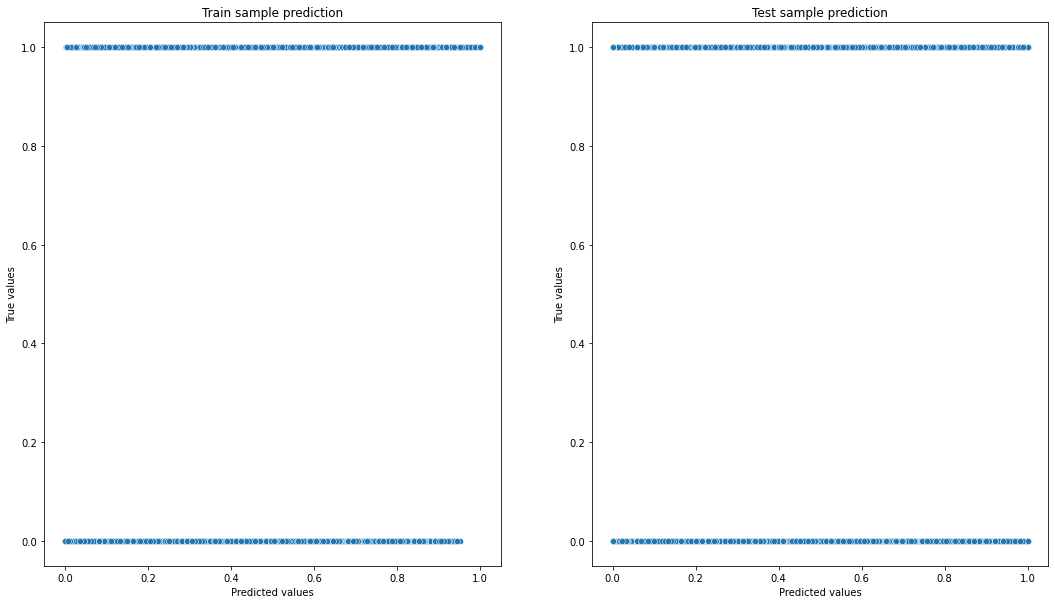

In [60]:
rf_model = RandomForestRegressor(random_state=21, criterion='mse', n_estimators=85)
rf_model.fit(X_train, y_train)

y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_valid)
print(mean_squared_error(y_valid, y_test_preds))
evaluate_preds(y_train.values.ravel(), y_train_preds, y_valid.values.ravel(), y_test_preds)

**Кросс-валидация**

In [61]:
cv_score = cross_val_score(rf_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=21))
cv_score

array([0.47927635, 0.47597848, 0.47726412])

In [62]:
cv_score.mean()

0.47750631783532493

**Важность признаков**

In [63]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
3,PATIENT_TYPE,0.349813
6,AGE,0.168989
4,INTUBED,0.118023
1,MEDICAL_UNIT,0.087928
18,CLASIFFICATION_FINAL,0.051147
0,USMER,0.026649
15,OBESITY,0.021427
12,HIPERTENSION,0.020467
8,DIABETES,0.019365
20,IllDeathReason,0.018206
